# Mục mới

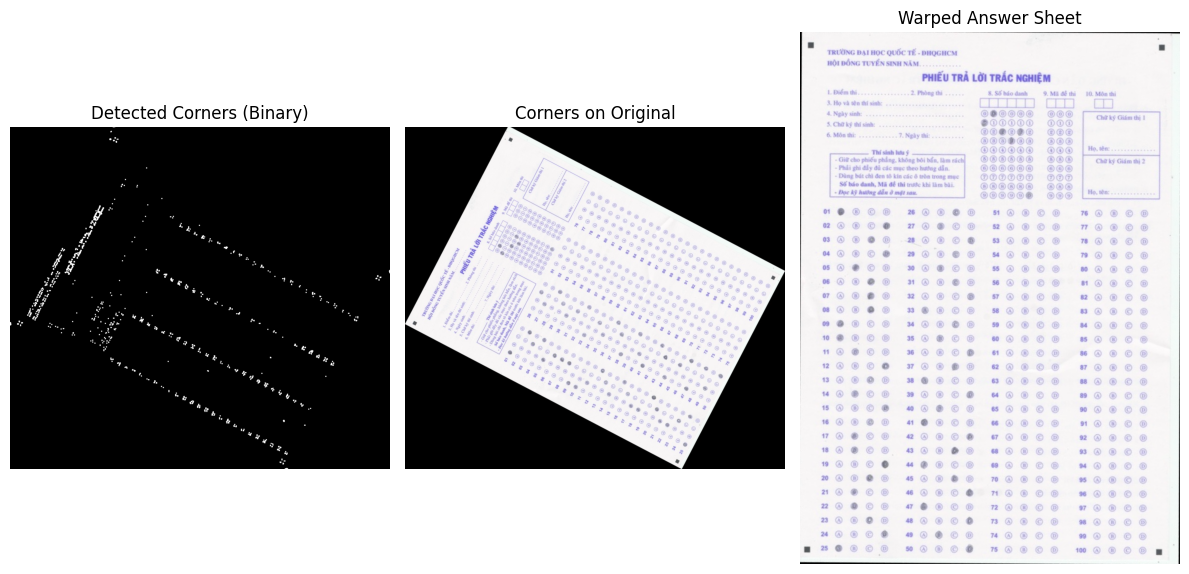

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
# Load the image
img = cv2.imread("lab5.jpg")
orig = img.copy()

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray)
original = img.copy()
gray_float = np.float32(img_gray)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst = cv2.dilate(dst, None)

corner_img = np.zeros_like(img_gray)
corner_img[dst > 0.01 * dst.max()] = 255

corner_points = np.argwhere(dst > 0.01 * dst.max())
corner_points = np.flip(corner_points, axis=1)  # (x, y)

hull = cv2.convexHull(corner_points)
epsilon = 0.02 * cv2.arcLength(hull, True)
approx = cv2.approxPolyDP(hull, epsilon, True)

if len(approx) != 4:
    raise ValueError("Could not find exactly 4 corners. Try adjusting epsilon or check the input image.")

def order_points(pts):
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]     # top-left
    rect[2] = pts[np.argmax(s)]     # bottom-right
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect

ordered_pts = order_points(approx)
(tl, tr, br, bl) = ordered_pts

widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))

heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

dst_pts = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")

M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)
warped = cv2.warpPerspective(original, M, (maxWidth, maxHeight))

if maxWidth > maxHeight:
    warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(corner_img, cmap='gray')
plt.title("Detected Corners (Binary)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corners on Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Warped Answer Sheet")
plt.imshow(warped)
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:

import cv2
import math
import numpy as np
import random

def drawText(image, txt):
	# font
	font = cv2.FONT_HERSHEY_SIMPLEX
	# org
	org = (50, 50)
	# fontScale
	fontScale = 1
	# Blue color in BGR
	color = (255, 0, 0)
	# Line thickness of 2 px
	thickness = 2
	# Using cv2.putText() method
	image = cv2.putText(image, txt, org, font,
						fontScale, color, thickness, cv2.LINE_AA)
	return

# Ham tinh khoang cach giua hai deim
def distance(p1,p2):
    my_dist = math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))
    return  my_dist

def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

def order_points(pts):

	rect = np.zeros((4, 2), dtype="float32")

	s = pts.sum(axis=1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis=1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):


	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

def find_corner_by_rotated_rect(box,approx):
    corner = []
    for p_box in box:
        min_dist = 999999999
        min_p = None
        for p in approx:
            dist = distance(p_box, p[0])
            if dist < min_dist:
                min_dist = dist
                min_p = p[0]
        corner.append(min_p)

    corner = np.array(corner)
    return corner



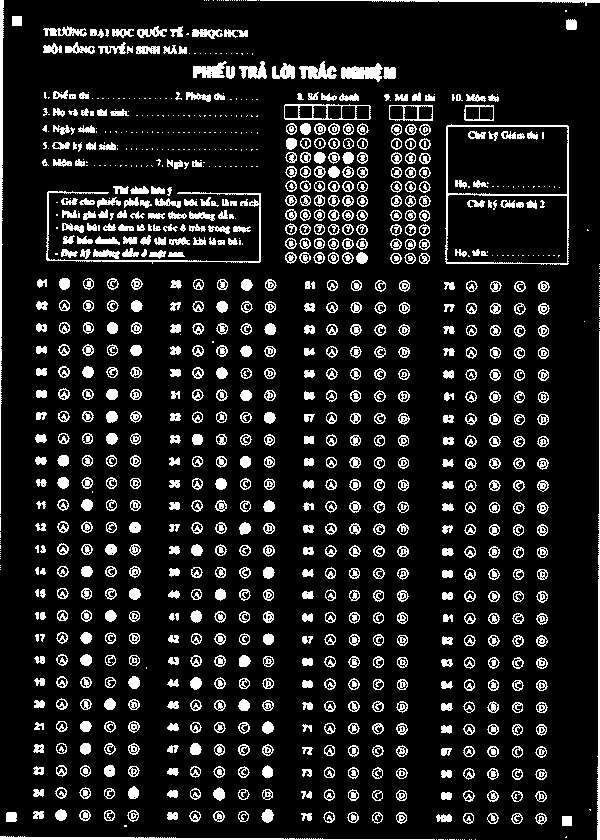

In [15]:
img_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
_, negative_binary = cv2.threshold(img_gray, 220, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(negative_binary)

Segment 1: rows 0 to 3


Segment 2: rows 16 to 38


Segment 3: rows 43 to 54


Segment 4: rows 62 to 79


Segment 5: rows 92 to 102


Segment 6: rows 104 to 121


Segment 7: rows 123 to 151


Segment 8: rows 152 to 178


Segment 9: rows 180 to 265


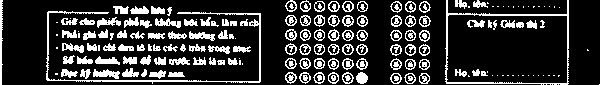

Segment 10: rows 278 to 292


Segment 11: rows 300 to 314


Segment 12: rows 322 to 336


Segment 13: rows 345 to 359


Segment 14: rows 367 to 381


Segment 15: rows 389 to 403


Segment 16: rows 411 to 425


Segment 17: rows 433 to 447


Segment 18: rows 455 to 469


Segment 19: rows 477 to 491


Segment 20: rows 499 to 513


Segment 21: rows 522 to 536


Segment 22: rows 544 to 558


Segment 23: rows 566 to 580


Segment 24: rows 588 to 602


Segment 25: rows 610 to 624


Segment 26: rows 632 to 647


Segment 27: rows 655 to 669


Segment 28: rows 677 to 691


Segment 29: rows 699 to 713


Segment 30: rows 721 to 735


Segment 31: rows 743 to 757


Segment 32: rows 765 to 780


Segment 33: rows 787 to 802


Segment 34: rows 810 to 826


Segment 35: rows 836 to 840


In [16]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# B1: Tính số pixel trắng mỗi hàng
white_pixel_count = np.sum(negative_binary == 255, axis=1)

# B2: Xác định vùng liên tiếp mà white_pixel_count != 0 (tức là vùng có thông tin)
regions = []
in_region = False

for i, count in enumerate(white_pixel_count):
    if count > 10 and not in_region:
        start = i
        in_region = True
    elif count <10 and in_region:
        end = i
        in_region = False
        regions.append((start, end))

# Nếu kết thúc vẫn đang trong vùng
if in_region:
    regions.append((start, len(white_pixel_count)))

# B3: Cắt và hiển thị từng vùng
for idx, (start, end) in enumerate(regions):
    cropped = negative_binary[start:end]
    print(f"Segment {idx+1}: rows {start} to {end}")
    cv2_imshow(cropped)


In [17]:
part1 = []
part2 = []

for seg_idx, (start, end) in enumerate(regions[9:34]):
    segment = negative_binary[start:end]
    h, w = segment.shape

    # Tính chiều rộng mỗi phần
    part_width = w // 4

    for part_idx in range(4):
        x_start = part_idx * part_width + 15
        x_end = (part_idx + 1) * part_width if part_idx < 3 else w  # tránh mất cột cuối

        part = segment[:, x_start:x_end]
        if (part_idx ==0):
          part1.append (part)
        elif (part_idx ==1):
          part2.append (part)


In [18]:
# Crop 10 pixels from the left of each part in part1
part1 = [p[:, 15:] for p in part1]
part2 = [p[:, :-15] for p in part2]


for part in part1:
  cv2_imshow(part)
for part in part2:
  cv2_imshow(part)

In [19]:
import cv2
import numpy as np

def detect_selected_answer(part, crop_left=10):
    # Bước 1: Cắt bỏ 10 pixel từ mép trái
    part_cropped = part[:, crop_left:]

    # Bước 2: Nhị phân lại nếu chưa làm (đảm bảo ảnh là 0 và 255)
    _, binary = cv2.threshold(part_cropped, 127, 255, cv2.THRESH_BINARY)

    # Bước 3: Chia ảnh thành 5 phần bằng nhau
    h, w = binary.shape
    num_options = 5
    option_width = w // num_options
    labels = ['A', 'B', 'C', 'D', 'E']
    white_counts = []

    for i in range(num_options):
        x_start = i * option_width
        x_end = (i + 1) * option_width if i < num_options - 1 else w
        option = binary[:, x_start:x_end]
        white_count = np.sum(option == 255)
        white_counts.append(white_count)

    # Bước 4: Chọn phần có số pixel trắng nhiều nhất
    selected_index = int(np.argmax(white_counts))
    selected_label = labels[selected_index]

    return selected_label, white_counts
for idx, part in enumerate(part1):
    answer, counts = detect_selected_answer(part)



In [20]:
ques = 1
def select_most_filled_column_with_index(parts, label=""):
    global ques  # Allow modification of the outer variable
    selected_columns = []
    for idx, part in enumerate(parts):
        h, w = part.shape
        col_width = w // 5
        max_white = -1
        selected = None
        selected_idx = -1

        for i in range(5):
            x_start = i * col_width
            x_end = (i + 1) * col_width if i < 4 else w
            column = part[:, x_start:x_end]

            white_pixels = cv2.countNonZero(column)
            if white_pixels > max_white:
                max_white = white_pixels
                selected = column
                selected_idx = i

        print(f"Question {ques} → selected answer: {selected_idx}")
        ques += 1
        selected_columns.append(selected)
    return selected_columns

# Process and display selected columns
selected_part1 = select_most_filled_column_with_index(part1)
selected_part2 = select_most_filled_column_with_index(part2)




Question 1 → selected answer: 1
Question 2 → selected answer: 4
Question 3 → selected answer: 3
Question 4 → selected answer: 4
Question 5 → selected answer: 2
Question 6 → selected answer: 3
Question 7 → selected answer: 3
Question 8 → selected answer: 3
Question 9 → selected answer: 1
Question 10 → selected answer: 1
Question 11 → selected answer: 2
Question 12 → selected answer: 4
Question 13 → selected answer: 3
Question 14 → selected answer: 2
Question 15 → selected answer: 4
Question 16 → selected answer: 3
Question 17 → selected answer: 2
Question 18 → selected answer: 2
Question 19 → selected answer: 4
Question 20 → selected answer: 3
Question 21 → selected answer: 2
Question 22 → selected answer: 2
Question 23 → selected answer: 3
Question 24 → selected answer: 4
Question 25 → selected answer: 1
Question 26 → selected answer: 3
Question 27 → selected answer: 2
Question 28 → selected answer: 4
Question 29 → selected answer: 3
Question 30 → selected answer: 2
Question 31 → selec